# Gamma Ray Bursts

In [105]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities\utils.py")
from Utilities import plot_settings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

from scipy.stats import norm

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

C:\Users\ricca\AppData\Local\Temp\ipykernel_3016\3973052632.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [3]:
T90  = data[6]
T90_err = data[7]
F    = data[9]
Ferr = data[10]
R    = data[11] 

In [124]:
def mask(X):
    # Elimina righe che contengono la stringa '-999'
    mask_valid = ~np.any(X == '-999', axis=1)
    Y = X[mask_valid]

    # Converte in float
    Y = Y.astype(float)

    # Elimina righe che contengono zero
    mask_nonzero = ~np.any(Y == 0.0, axis=1)
    Y_clean = Y[mask_nonzero]

    return Y_clean, Y_clean.shape[0]

I'd like to get the most data possible, even if I am not sure I'll get the most information out of them.

In [125]:
import itertools

In [126]:
array_list = [T90, F, R]
array_labels = ['T90', 'F', 'R']

# Ottieni tutte le coppie (combinazioni di 2)
array_pairs = list(itertools.combinations(array_list, 2))
label_pairs = list(itertools.combinations(array_labels, 2))

# Ciclo su tutte le coppie
for i, ((a1, a2), (label1, label2)) in enumerate(zip(array_pairs, label_pairs)):
    X = np.vstack([a1, a2]).T
    _, size = mask(X)
    print(f"{label1}-{label2}: {size} valid entries")

T90-F: 7514 valid entries
T90-R: 597 valid entries
F-R: 608 valid entries


In [127]:
X = np.vstack([F, Ferr, T90, T90_err]).T
Y, size = mask(X)

I want to look at relative errors

Text(0, 0.5, 'Flux ')

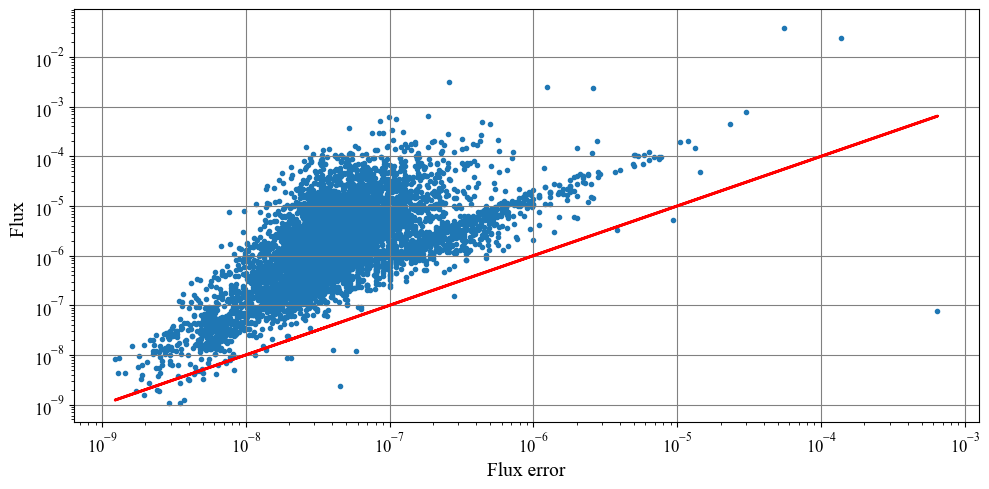

In [128]:
plt.scatter(Y.T[1], Y.T[0], marker='.')
plt.plot(Y.T[1], Y.T[1], lw=2, color='red')
plt.loglog()
plt.xlabel('Flux error')
plt.ylabel('Flux ')

Text(0, 0.5, 'T_90 ')

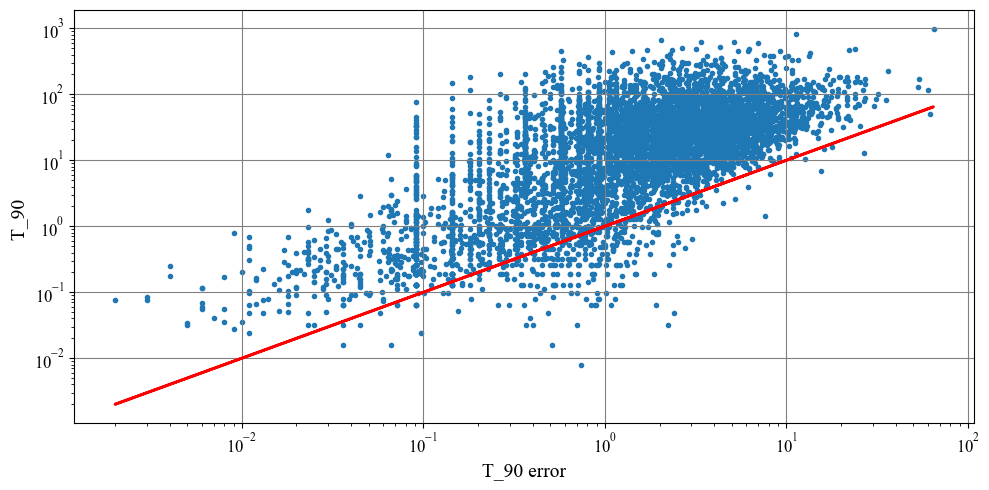

In [129]:
plt.scatter(Y.T[3], Y.T[2], marker='.')
plt.plot(Y.T[3], Y.T[3], lw=2, color='red')
plt.loglog()
plt.xlabel('T_90 error')
plt.ylabel('T_90 ')

All of the points appearing under the red line exhibit relative error bigger then 100%, thus they have to be discarded.\
I'll look now into the 1D distributions of T90 and fluence.

In [130]:
def mask2(X):
    # Elimina righe con valori mancanti '-999'
    mask_valid = ~np.any(X == '-999', axis=1)
    Y = X[mask_valid].astype(float)

    # Elimina righe con zeri
    mask_nonzero = ~np.any(Y == 0.0, axis=1)
    Y = Y[mask_nonzero]

    # Filtro: errore minore o uguale al valore misurato
    F, Ferr, T90, T90_err = Y.T  # unpack colonne
    mask_err_valid = (Ferr <= F) & (T90_err <= T90)

    Y_clean = Y[mask_err_valid]

    return Y_clean, Y_clean.shape[0]

In [131]:
X = np.vstack([F, T90]).T
Y, size = mask(X)

## Gaussian mixtures

Text(0, 0.5, 'Density')

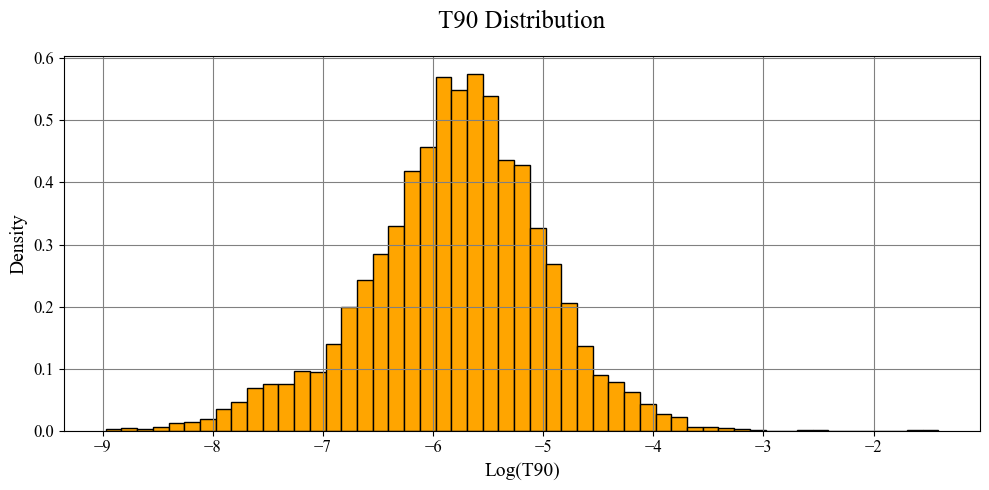

In [141]:
_,_,_ = plt.hist(np.log10(Y.T[0]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black')
plt.title('T90 Distribution')
plt.xlabel('Log(T90)')
plt.ylabel('Density')

In [154]:
n_range = range(2,7) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(GaussianMixture(), {'n_components': n_range}, cv= K, scoring=GaussianMixture.aic) # Try each bandwidth with K-folds
grid.fit(Y) #Fit the histogram data that we started the lecture with.

GridSearchCV(cv=5, estimator=GaussianMixture(),
             param_grid={'n_components': range(2, 7)},
             scoring=<function GaussianMixture.aic at 0x00000199F2E60EA0>)

In [155]:
estimator = grid.best_estimator_

In [156]:
estimator.fit(np.log10(Y.T[0]).reshape(-1,1))

GaussianMixture(n_components=2)

Text(0, 0.5, 'Density')

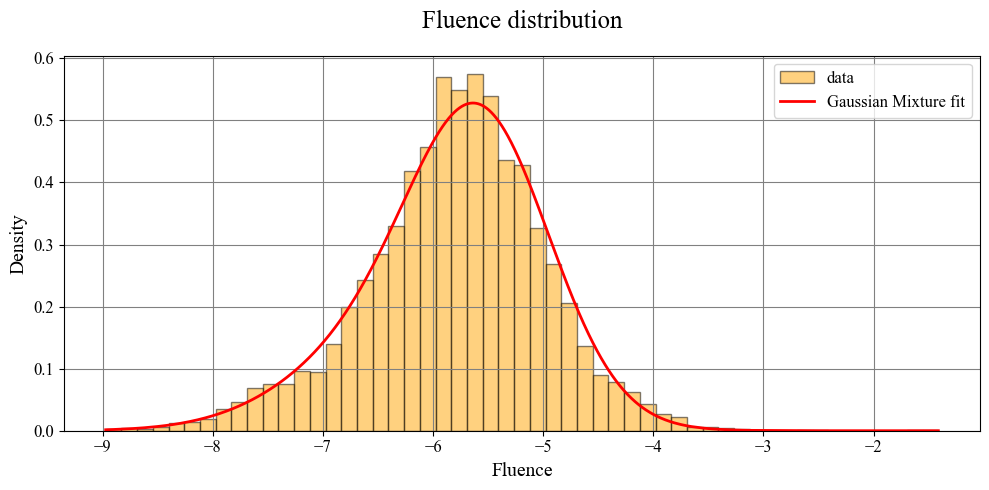

In [157]:
_,_,_ = plt.hist(np.log10(Y.T[0]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black', alpha=0.5, label='data')
x = np.sort(np.log10(Y.T[0]))
y = np.exp(estimator.score_samples(x.reshape(-1,1)))
plt.plot(x, y, lw=2, color='red', label='Gaussian Mixture fit')
plt.legend()
plt.title('Fluence distribution')
plt.xlabel('Fluence')
plt.ylabel('Density')

In [158]:
estimator.fit(np.log10(Y.T[1]).reshape(-1,1))

GaussianMixture(n_components=2)

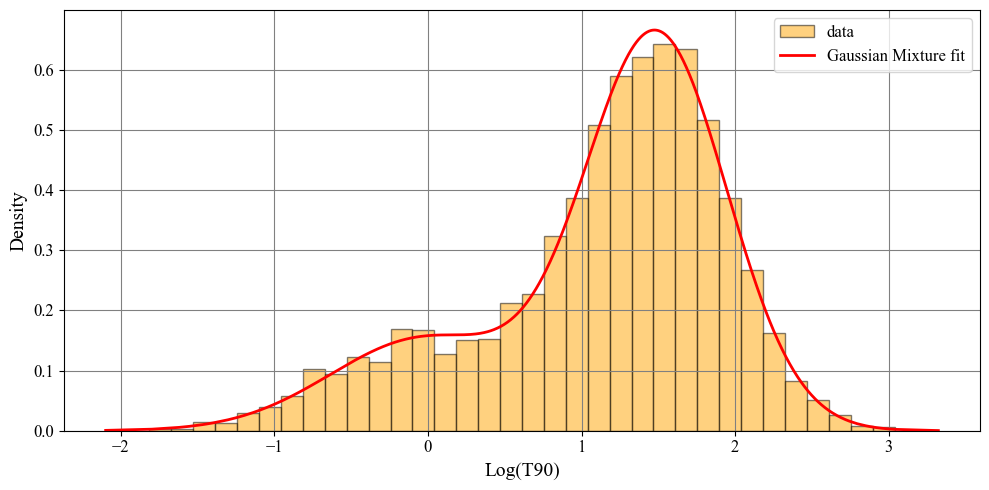

In [159]:
_,_,_ = plt.hist(np.log10(Y.T[1]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black', alpha=0.5, label='data')
x = np.sort(np.log10(Y.T[1]))
y = np.exp(estimator.score_samples(x.reshape(-1,1)))
plt.plot(x, y, lw=2, color='red', label='Gaussian Mixture fit')
plt.ylabel('Density')
plt.xlabel('Log(T90)')
plt.legend()

...2D?

In [160]:
gm = GaussianMixture(2, random_state=42)
gm.fit(Y)
labels = gm.predict(Y)

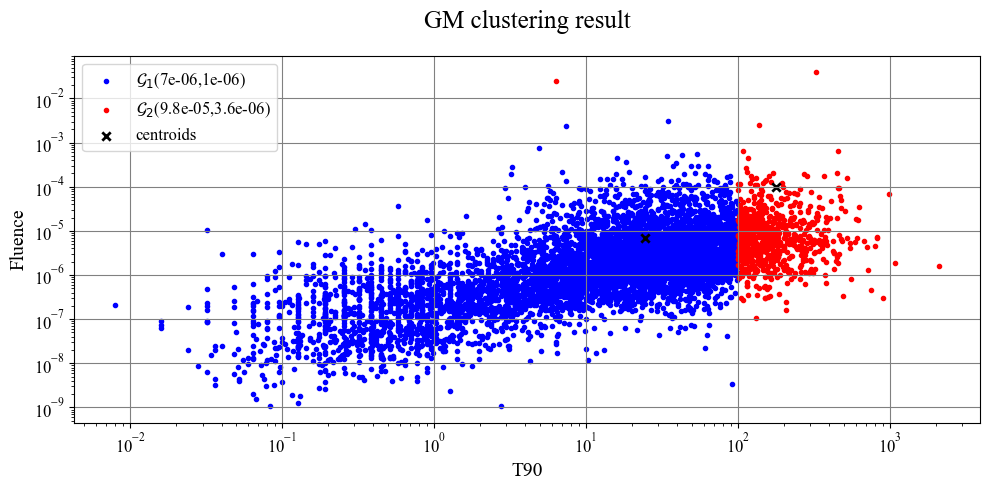

In [165]:
plt.scatter(Y.T[1][labels==0],Y.T[0][labels==0],marker='.', color='blue', label=r"$\mathcal{G}_1$"+f'({gm.means_[0][0]:.2},{gm.covariances_[0][0][0]:.2})')
plt.scatter(Y.T[1][labels==1],Y.T[0][labels==1],marker='.', color='red',  label=r"$\mathcal{G}_2$"+f'({gm.means_[1][0]:.2},{gm.covariances_[1][0][0]:.2})')
plt.scatter(gm.means_[:,1],gm.means_[:,0], marker='x', color='black', label='centroids')
plt.loglog()
plt.xlabel('T90')
plt.ylabel('Fluence')
plt.title('GM clustering result')
plt.legend()

In [104]:
print(f'Cluster 1:  G({gm.means_[0]}, {np.diag(gm.covariances_[0])})')
print(f'Cluster 2:  G({gm.means_[1]}, {np.diag(gm.covariances_[1])})')

Cluster 1:  G([7.04406200e-06 2.44381219e+01], [1.00255816e-06 6.10886285e+02])
Cluster 2:  G([9.75857381e-05 1.78309320e+02], [3.56571079e-06 1.97278163e+04])


Looks like in the data there are:
 1. Short GRBs with a mean time of $24.44 s$ and a mean fluence of $7.04\times10^{-6} \frac{\text{erg}}{\text{cm}^2}$
 2. Long GRBs with a mean time of $178.31 s$ and a mean fluence of $9.75\times10^{-5} \frac{\text{erg}}{\text{cm}^2}$
 
Thus longer GRBs are more frequent then shorter ones.

## K-Means

In [86]:
n_range = range(2,7) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KMeans(), {'n_clusters': n_range}, cv= K, scoring=KMeans.score) # Try each bandwidth with K-folds
grid.fit(Y) #Fit the histogram data that we started the lecture with.

GridSearchCV(cv=5, estimator=KMeans(), param_grid={'n_clusters': range(2, 7)},
             scoring=<function _BaseKMeans.score at 0x00000199F2738D60>)

In [87]:
km = KMeans(n_clusters=2, random_state=42)
labels = km.fit_predict(Y)

In [88]:
x_greens = Y.T[0][labels == 0]
y_greens = Y.T[1][labels == 0]
x_red = Y.T[0][labels == 1]
y_red = Y.T[1][labels == 1]

Text(0.5, 1.0, 'Clustering result')

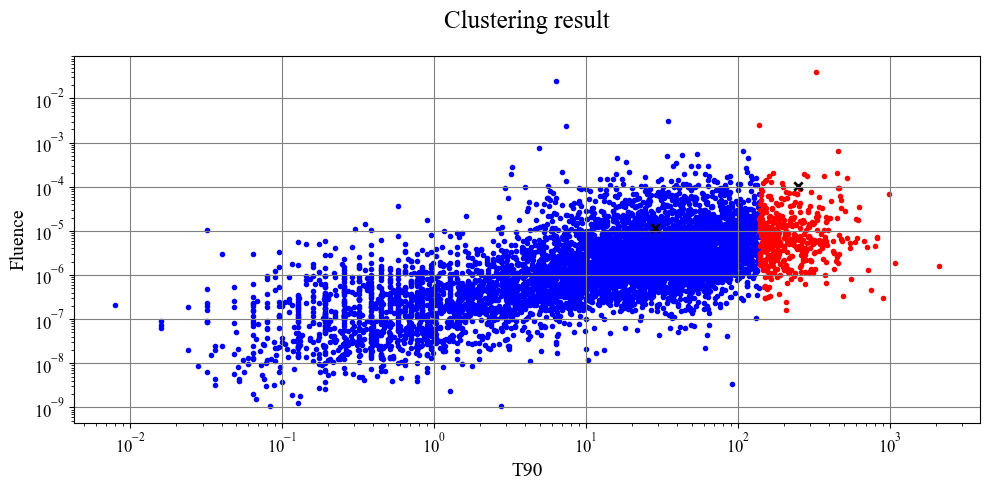

In [177]:
plt.scatter(y_greens, x_greens, marker='.', color='blue')
plt.scatter(y_red, x_red, marker='.', color='red')
plt.scatter(km.cluster_centers_[:,1], km.cluster_centers_[:,0], marker='x', color='black')
plt.xlabel('T90')
plt.ylabel('Fluence')
plt.loglog()
plt.title('Clustering result')

In [181]:
for i,a in enumerate(['Fluence', 'T90']):
    print(a)
    for l,c,m in zip(['Short GRBs','Long GRBs'],np.sort(km.cluster_centers_[:,i]),np.sort(gm.means_[:,i])):
        print(l,": ", c,m, np.abs(c-m)/np.mean([c,m]) )
        

Fluence
Short GRBs :  1.1436467015161779e-05 7.044061997162496e-06 0.47535490083320464
Long GRBs :  0.00010678010942791766 9.758573809172681e-05 0.0899795288477156
T90
Short GRBs :  28.572701003249968 24.438121918734282 0.15598999814058814
Long GRBs :  247.86405263157906 178.30932016493472 0.32641519581682


## Mean-shift

In [ ]:
inertia = []
k_range = np.power(10, np.linspace(-4,1,5))

for k in k_range:
    print(k)
    ms = MeanShift(bandwidth=k)
    inertia.append(silhouette_score(Y, ms.fit_predict(Y)))

0.0001
0.0017782794100389228
0.03162277660168379
0.5623413251903491
10.0


Best k is 0.03162277660168379


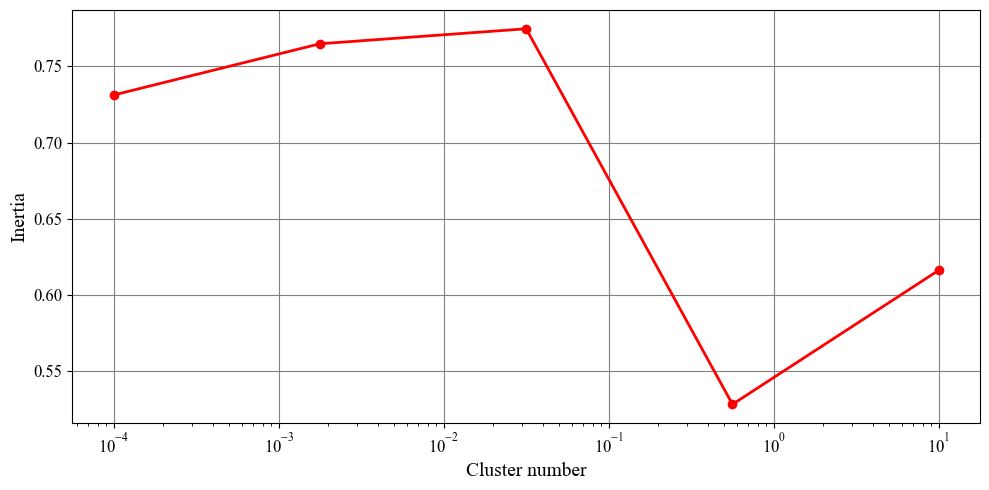

In [31]:
plt.plot(k_range, inertia, marker='o', color='red')
plt.xlabel('Cluster number')
plt.ylabel('Inertia')
plt.xscale('log')

best_k = k_range[np.argmax(inertia)]
print('Best k is', best_k)

In [41]:
ms = MeanShift()
labels = ms.fit_predict(Y)

In [42]:
cluster_centers = ms.cluster_centers_
n_clusters = len(np.unique(labels))

In [43]:
cluster_centers.size

30

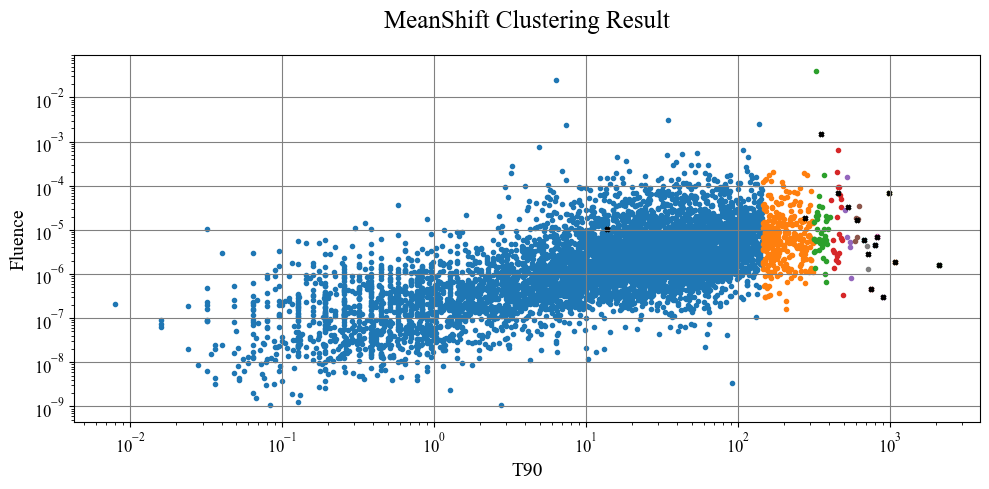

In [46]:
for i in range(n_clusters):
    plt.scatter(Y.T[1][labels == i], Y.T[0][labels == i], marker='.', label=f'Cluster {i}')

# Plot cluster centers
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], 
            color='black', marker='x', s=10, label='Centroids')

plt.xlabel('T90')
plt.ylabel('Fluence')
plt.loglog()
plt.title('MeanShift Clustering Result')
plt.grid(True)
plt.tight_layout()